# |In this notebook we fit a SEIR model to the OWID Russia Covid-19 data

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy
from sklearn.metrics import mean_absolute_error

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [10]:
from sir_models.models import SEIR
from sir_models.fitters import CurveFitter
from sir_models.utils import stepwise, eval_k_days_ahead

# Load data

In [11]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [12]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,0,0,0,0,0
new_deaths,0,0,0,0,0
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


In [18]:
df = df.fillna(0)

# Define model and fitter

In [19]:
class SEIR_OWID(SEIR):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['base_population'].value = df.iloc[0].population
        return params


# Model

In [20]:
train_subset = df[
                #(df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52407,Russia,2020-02-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52408,Russia,2020-02-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52409,Russia,2020-02-03,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52410,Russia,2020-02-04,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0


In [21]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [22]:
stepwize_size = 60
model = SEIR_OWID(stepwise_size=stepwize_size)
fitter = CurveFitter(
     total_deaths_col='total_deaths',
     new_deaths_col='new_deaths_smoothed',
     total_cases_col='total_cases',
     new_cases_col='new_cases_smoothed',
#      brute_params=['epidemic_started_days_ago']
)
fitter.fit(model, train_subset)

In [23]:
result = fitter.result
result

In [26]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)
new_exposed, new_infected, new_recovered, new_dead = model.compute_daily_values(S, E, I, R, D)

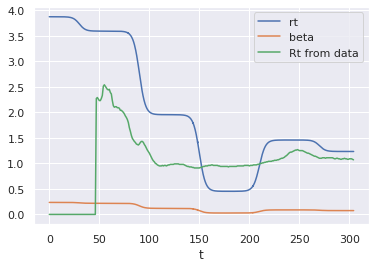

In [27]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(train_t, train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

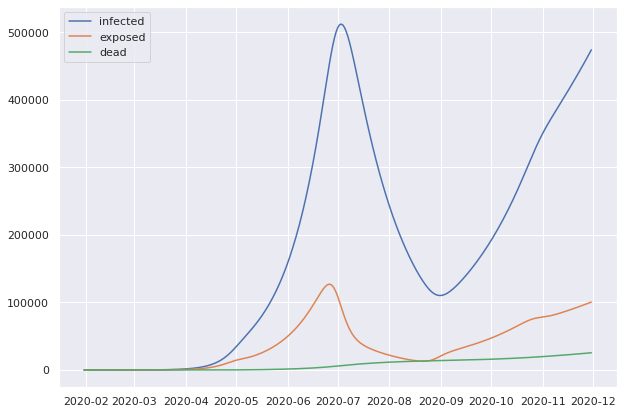

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

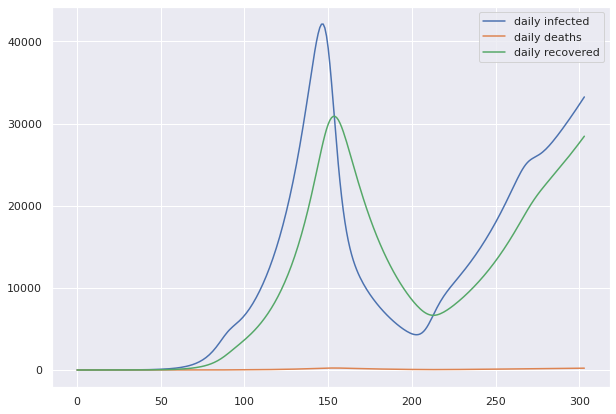

In [29]:
plt.figure(figsize=(10, 7))
plt.plot(new_infected, label='daily infected')
plt.plot(new_dead, label='daily deaths')
plt.plot(new_recovered, label='daily recovered')
plt.legend()
plt.show()

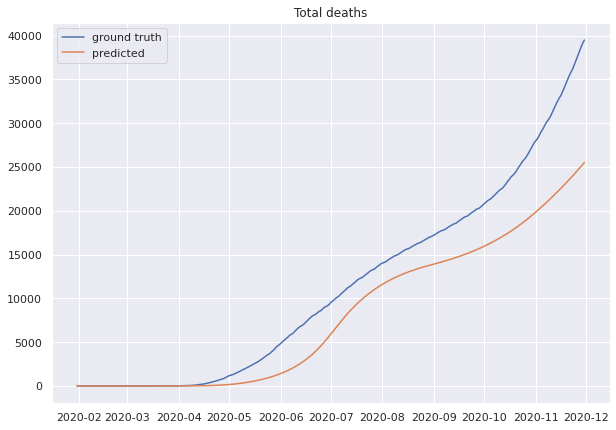

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

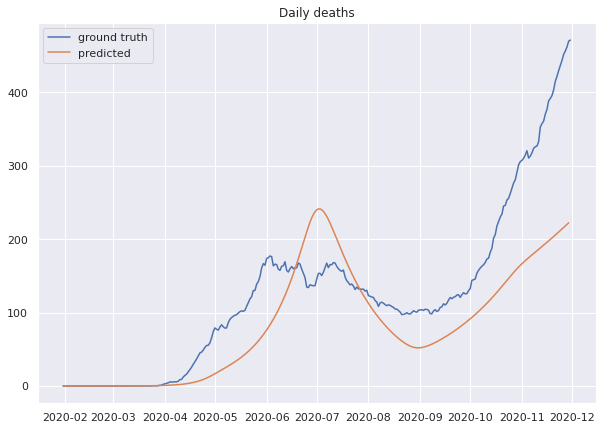

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.plot(train_subset.date[:-1], new_dead, label='predicted')
plt.legend()
plt.title('Daily deaths')
plt.show()

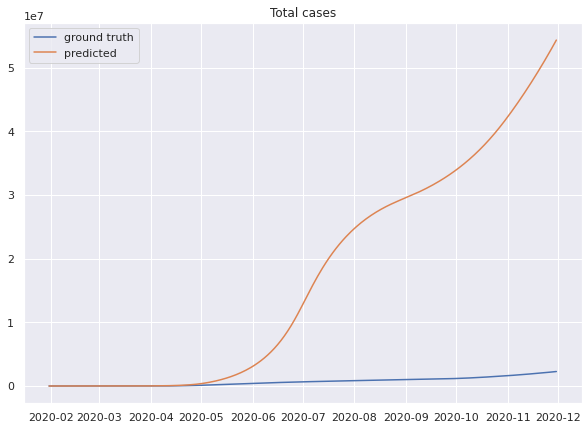

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total cases')
plt.show()

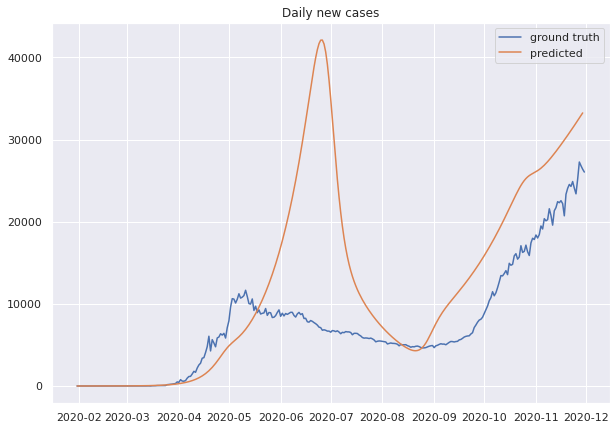

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')
plt.plot(train_subset.date[:-1], new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

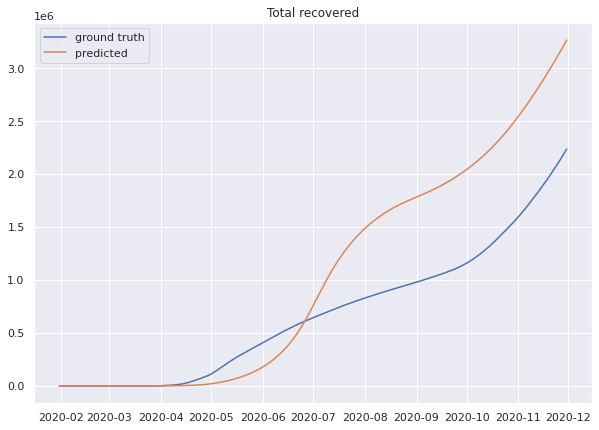

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset.total_cases - train_subset.total_deaths, label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

# Obtain forecast

In [35]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [36]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [37]:
test_initial_conds = (S[-1], E[-1], I[-1], R[-1], D[-1])

In [38]:
(test_S, test_E, test_I, test_R, test_D), history = model.predict(test_t, test_initial_conds)

In [41]:
test_new_exposed, test_new_infected, test_new_recovered, test_new_dead = model.compute_daily_values(test_S, test_E, test_I, test_R, test_D)

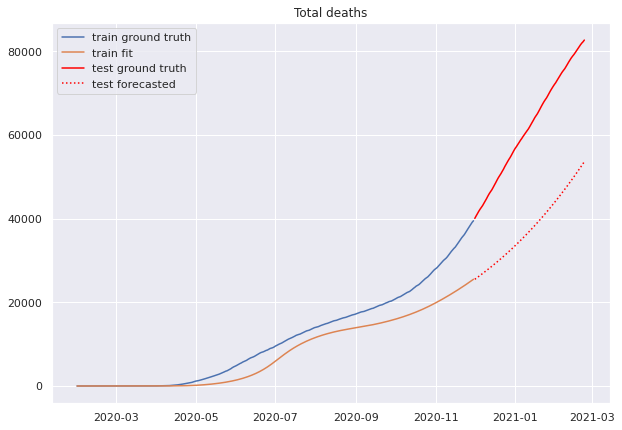

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

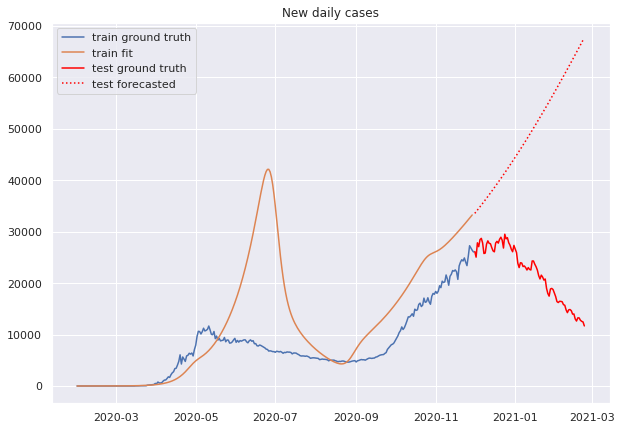

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='train ground truth')
plt.plot(train_subset.date[:-1], new_infected, label='train fit')

plt.plot(test_subset.date, test_subset['new_cases'], label='test ground truth', color='red')
plt.plot(test_subset.date[:-1], test_new_infected, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('New daily cases')
plt.show()

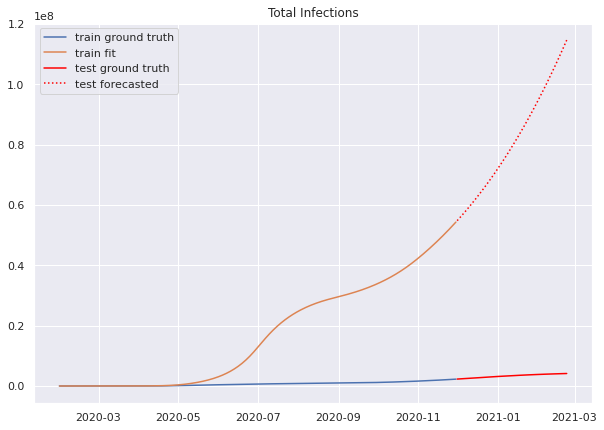

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total Infections')
plt.show()

# 1-day ahead evaluate

In [52]:
eval_period_start_t = len(df[df.date <= '2020-05-01'])
eval_period_start_t

92

In [53]:
pred_dates, baseline_pred_D, model_pred_D, true_D, fitters = eval_k_days_ahead(df,
                                                                      SEIR_OWID, 
                                                                      CurveFitter,
                                                                      eval_period_start=eval_period_start_t,
                                                                      n_eval_points=10, 
                                                                      total_dead_col='total_deaths', 
                                                                      fitter_kwargs=dict(verbose=True,
                                                                                         total_deaths_col='total_deaths',
                                                                                         new_deaths_col='new_deaths_smoothed',
                                                                                         total_cases_col='total_cases',
                                                                                         new_cases_col='new_cases_smoothed'),
                                                                      k=30)

In [56]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [65]:
print('Median overall error baseline', np.median(overall_errors_baseline))
print('Median overall error model', np.median(overall_errors_model))

print('Median point 30 days ahead error baseline', np.median(point_errors_baseline))
print('Median point 30 days ahead error model', np.median(point_errors_model))

Median overall error baseline 2420.2666666666664
Median overall error model 12892.4704273321
Median point 30 days ahead error baseline 5030.0
Median point 30 days ahead error model 16008.825987509463


In [66]:
train_errors = [np.abs([f.result.residual]).mean() for f in fitters]
test_errors = [np.abs(fitters[0].resid_transform(true, pred)).mean() for true, pred in zip(true_D, model_pred_D)]

NameError: name 'fitters' is not defined

In [67]:
x_dates = [d[-1] for d in pred_dates]

In [68]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, train_errors, label='Model train error', marker='o')
plt.plot(x_dates, test_errors, label='Model test error', marker='o')
plt.ylabel("SMAPE")
plt.legend()
plt.title('Train error and test error')
plt.show()

NameError: name 'train_errors' is not defined

<Figure size 720x504 with 0 Axes>

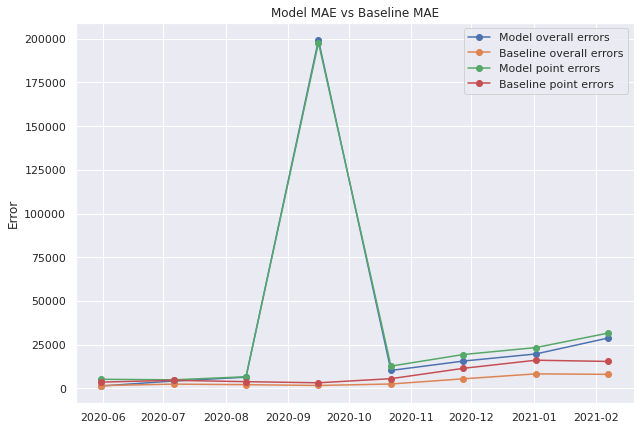

In [69]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors', marker='o')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors', marker='o')

plt.plot(x_dates, point_errors_model, label='Model point errors', marker='o')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors', marker='o')

plt.ylabel('Error')
plt.legend()
plt.title('Model MAE vs Baseline MAE')
plt.show()

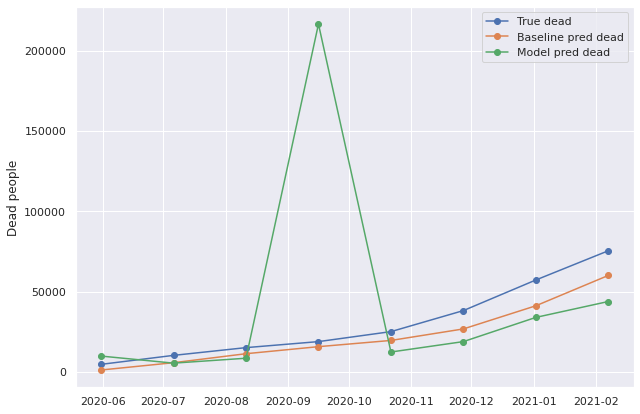

In [70]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, [v[-1] for v in true_D], label='True dead', marker='o')
plt.plot(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead', marker='o')
plt.plot(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead', marker='o')

plt.ylabel('Dead people')
plt.legend()
plt.show()